In [13]:
import os
import sys
import tskit
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import SVG

def run_bash_script(script):
    import subprocess
    return subprocess.check_output(script, shell=True, text=True, executable='/bin/bash')


def sleepy(n_simulations, num_generations=10000, N=50, m=1, b=1, gc=20, mu=0, r=5e-7, L=5000, mu_selection_rates="5e-8", 
         selection_coefficients="2",dominance_coefficients="0.5", selection_positions="2500", selection_activation_generation=500,
         mutation_in_seeds=True, stop_after_mrca=False, debug_print=False, output_name="run", 
         output_directory="./",n_parallel=10, continue_from=0, print_cmd=False, slurm=False
        ):
    
    kwargs = {"num_generations":num_generations,"N":N, "m":m, "b":b, "gc":gc, "mu":mu, "r":r, "L":L, "mu_selection_rates":mu_selection_rates, 
         "selection_coefficients":selection_coefficients,"dominance_coefficients":dominance_coefficients, "selection_positions":selection_positions, "selection_activation_generation":selection_activation_generation,
         "mutation_in_seeds":mutation_in_seeds, "stop_after_mrca":stop_after_mrca, "debug_print":debug_print, "output_name":output_name, 
         "output_directory":output_directory }
    
    cmd_arg_part = ""
    for k,v in zip(kwargs.keys(), kwargs.values()):
        cmd_arg_part += "--" + str(k) + " " + str(v) 
        if k == "output_name":
            cmd_arg_part += str("_$i")
        cmd_arg_part += " "
    
    if slurm:
        script = "sleepy " + cmd_arg_part
    else:    
        script = """

            n_simulations=""" + str(n_simulations) + """
            n_prog=""" + str(n_parallel) + """
            n_prog_count=0

            i=""" + str(continue_from) + """
            while [[ $i -lt $n_simulations ]]; do

            sleepy """ + cmd_arg_part + """ &
                 (( n_prog_count+=1 ))  
                 [[ $((n_prog_count%n_prog)) -eq 0 ]] && wait
                 (( i+=1 ))
            done
            """
    
    if print_cmd: print(script)
    else: return run_bash_script(script)


sleepy(5, print_cmd=True)

def subfig_diversity(models, ax, y_label=False, font_scale=0.8, legend_pos=-0.05):
    diversity_frame = pd.concat(models)
    sns.set(style= "white",palette="colorblind", font_scale=font_scale)  
    sns.lineplot(data=diversity_frame, x="positions", y="value", hue="model", ax=ax)
    if y_label: ax.set(xlabel='positions', ylabel='genetic diversity\n (tajima\'s pi)')
    else: ax.set(xlabel='positions', ylabel='')
        
        
    #ax.legend(loc='lower right')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, legend_pos),
              fancybox=True, shadow=True)
    
    ax.grid(alpha=0.5)
    

def get_diversity(directory,model, span_normalise=True, use=None, mode="branch"):
    trees_path, _ = get_path_trees_recorders(directory)
    diversities = []
    #recorder = None
    for i in range(len(trees_path)):
        ts = tskit.load(trees_path[i])
        windows = np.linspace(0, ts.sequence_length, 50)
        diversity = ts.diversity(windows=windows, span_normalise=span_normalise,   mode=mode )
        diversities.append(diversity)
    diversities = pd.DataFrame(diversities).fillna(0)
    diversities = diversities.T
    diversities['positions'] = windows[:-1]
    diversities = diversities.melt("positions")
    diversities['model'] = model
    return diversities

def get_path_trees_recorders(directory):
    files = np.array(os.listdir(directory))
    recorder_mask = [True if "csv" in i else False for i in files]
    trees_mask = [False if "csv" in i else True for i in files]
    recorders = files[recorder_mask].tolist()
    trees = files[trees_mask].tolist()
    trees.sort()
    recorders.sort()
    trees = [directory + i for i in trees]
    recorders = [directory + i for i in recorders]
    return trees, recorders



from os.path import basename, abspath


In [107]:
4*100*5000*5e-7

1.0

In [110]:
for i in [0.25, 0.5, 0.75, 1.0]:
    i = (round(i,2))
    output_directory = "./data/N100_b" + str(i) + "_m50_mu5e-7_r5e-7_muselec5e-8_seleccoef2_domcoef0.5_seqlen5000_selecpos2500_museed1s/"

    sleepy(n_simulations=50,num_generations=10000, N=100, m=50, b=i, gc=20, mu=5e-7, r=5e-7, L=5000, mu_selection_rates="5e-8", 
             selection_coefficients="2",dominance_coefficients="0.5", selection_positions="2500",
             mutation_in_seeds=True, stop_after_mrca=False, debug_print=False, output_name="run",
             selection_activation_generation=500,
             output_directory=output_directory,n_parallel=10, continue_from=0, print_cmd=False);

In [124]:
models = []
for i in [0.25, 0.5, 0.75, 1.0]:
    i = (round(i,2))
    path = "./data/N100_b" + str(i) + "_m50_mu5e-7_r5e-7_muselec5e-8_seleccoef2_domcoef0.5_seqlen5000_selecpos2500_museed1s/"
    model = get_diversity(path, basename(abspath(path)))
    models.append(model)

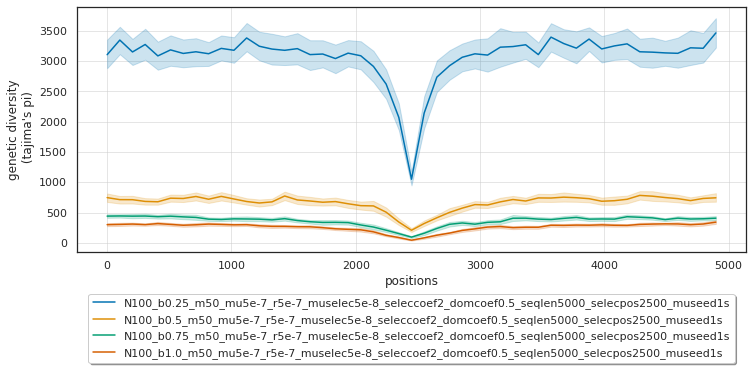

In [125]:
fig, axs = plt.subplots(1, 1,figsize=(12, 5), sharex=True, sharey=True)
subfig_diversity(models, ax=axs, y_label=True, font_scale=1, legend_pos=-0.15)

In [126]:
models = []
for i in [0.25, 0.5, 0.75, 1.0]:
    i = (round(i,2))
    path = "./data/N100_b" + str(i) + "_m50_mu5e-7_r5e-7_muselec5e-8_seleccoef2_domcoef0.5_seqlen5000_selecpos2500_museed1s/"
    model = get_diversity(path, basename(abspath(path)), mode="site")
    models.append(model)

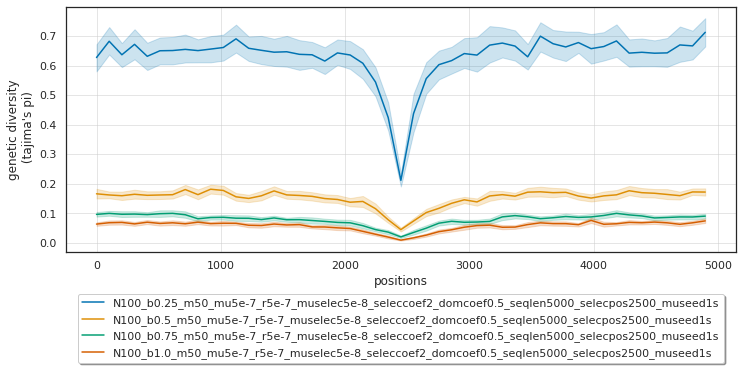

In [127]:
fig, axs = plt.subplots(1, 1,figsize=(12, 5), sharex=True, sharey=True)
subfig_diversity(models, ax=axs, y_label=True, font_scale=1, legend_pos=-0.15)

In [128]:
for i in [0.5, 0.75, 1.0]:
    i = (round(i,2))
    output_directory = "./data/N100_b" + str(i) + "_m50_mu5e-7_r5e-7_muselec5e-8_seleccoef2_domcoef0.5_seqlen5000_selecpos2500_museed0s/"

    sleepy(n_simulations=50,num_generations=10000, N=100, m=50, b=i, gc=20, mu=5e-7, r=5e-7, L=5000, mu_selection_rates="5e-8", 
             selection_coefficients="2",dominance_coefficients="0.5", selection_positions="2500",
             mutation_in_seeds=False, stop_after_mrca=False, debug_print=False, output_name="run",
             selection_activation_generation=500,
             output_directory=output_directory,n_parallel=10, continue_from=0, print_cmd=False);

In [130]:
models = []
for i in [0.5, 0.75, 1.0]:
    i = (round(i,2))
    path = "./data/N100_b" + str(i) + "_m50_mu5e-7_r5e-7_muselec5e-8_seleccoef2_domcoef0.5_seqlen5000_selecpos2500_museed0s/"
    model = get_diversity(path, basename(abspath(path)), mode="site")
    models.append(model)

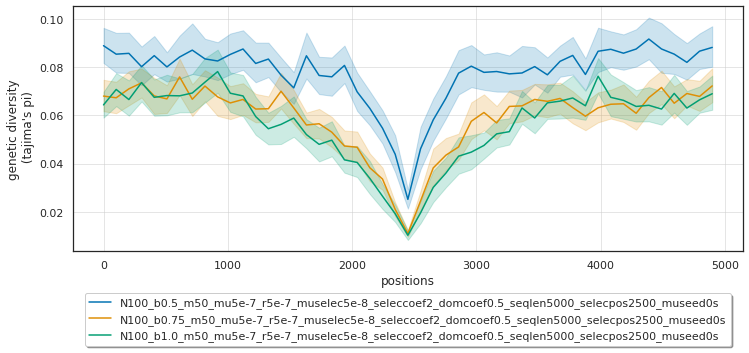

In [131]:
fig, axs = plt.subplots(1, 1,figsize=(12, 5), sharex=True, sharey=True)
subfig_diversity(models, ax=axs, y_label=True, font_scale=1, legend_pos=-0.15)

In [132]:
for i in [0.5, 0.75, 1.0]:
    i = (round(i,2))
    output_directory = "./data/N100_b" + str(i) + "_m50_mu5e-7_r5e-7_muselec5e-8_seleccoef2_domcoef0.5_seqlen10_selecpos5_museed0s/"

    sleepy(n_simulations=50,num_generations=10000, N=100, m=50, b=i, gc=20, mu=5e-7, r=5e-7, L=10, mu_selection_rates="5e-8", 
             selection_coefficients="2",dominance_coefficients="0.5", selection_positions="5",
             mutation_in_seeds=False, stop_after_mrca=False, debug_print=False, output_name="run",
             selection_activation_generation=500,
             output_directory=output_directory,n_parallel=10, continue_from=0, print_cmd=False);

In [30]:
models = []
for i in [0.5, 0.75, 1.0]:
    i = (round(i,2))
    path = "./data/N100_b" + str(i) + "_m50_mu5e-7_r5e-7_muselec5e-8_seleccoef2_domcoef0.5_seqlen10_selecpos5_museed0s/"
    model = get_diversity(path, basename(abspath(path)), mode="branch")
    models.append(model)

FileNotFoundError: [Errno 2] No such file or directory: './data/N100_b0.5_m50_mu5e-7_r5e-7_muselec5e-8_seleccoef2_domcoef0.5_seqlen10_selecpos5_museed0s/'

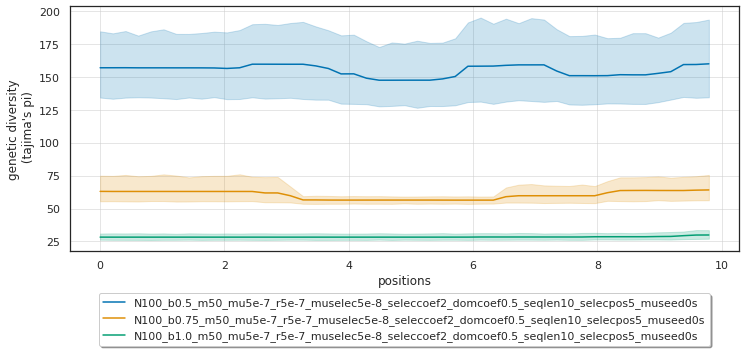

In [136]:
fig, axs = plt.subplots(1, 1,figsize=(12, 5), sharex=True, sharey=True)
subfig_diversity(models, ax=axs, y_label=True, font_scale=1, legend_pos=-0.15)

In [221]:
for i in range(100000):
    fixed = 1 in np.random.poisson(1e-11*10000, 1000)
    if fixed:
        print(i)

1862
29789
36907
39810
62452
68725
76753
89171
90070
91725
93147


In [254]:
for i in [1.0,0.5]:
    i = (round(i,2))
    output_directory = "./data/N500_b" + str(i) + "_m100_mu5e-5_r1e-4_muselec1e-9_seleccoef1_domcoef0.5_seqlen10000_selecpos5000_museed1s/"

    sleepy(n_simulations=1, num_generations=1000000, N=500, m=100, b=i, gc=50, mu=5e-5, r=1e-4, L=10000, mu_selection_rates="1e-9", 
             selection_coefficients="1",dominance_coefficients="0.5", selection_positions="5000",
             mutation_in_seeds=True, stop_after_mrca=False, debug_print=False, output_name="run",
             selection_activation_generation=20000,
             output_directory=output_directory,n_parallel=10, continue_from=0, print_cmd=False, slurm=False);

In [242]:
models = []
for i in [1.0, 0.5]:
    i = (round(i,2))
    path = "./data/N500_b" + str(i) + "_m100_mu5e-5_r1e-4_muselec1e-10_seleccoef1_domcoef0.5_seqlen10000_selecpos5000_museed1s/"
    model = get_diversity(path, basename(abspath(path)), mode="site")
    models.append(model)

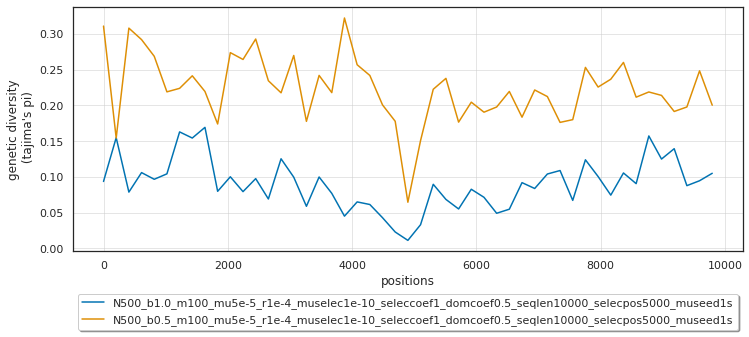

In [243]:
fig, axs = plt.subplots(1, 1,figsize=(12, 5), sharex=True, sharey=True)
subfig_diversity(models, ax=axs, y_label=True, font_scale=1, legend_pos=-0.15)

In [247]:
freqs = pd.read_csv("./data/N500_b0.5_m100_mu5e-5_r1e-4_muselec1e-10_seleccoef1_domcoef0.5_seqlen10000_selecpos5000_museed1s/run_0.csv")

In [252]:
freqs.position.unique()

array([5000.61, 5000.48, 5000.72, 5000.29, 5000.01, 5000.17])

In [253]:
freqs

,position,origin_generation,abs_population_freq,selection_coefficient,dominance_coefficient,active_mutations,current_generation
0,5000.61,1,1,1,0.5,1,55628
1,5000.61,2,1,1,0.5,1,55629
2,5000.48,3,1,1,0.5,1,58425
3,5000.48,4,1,1,0.5,1,58426
4,5000.72,0,1,1,0.5,1,29815
...,...,...,...,...,...,...,...
150,5000.29,149,1000,1,0.5,1,73074
151,5000.01,2,1,1,0.5,1,57655
152,5000.01,3,1,1,0.5,1,57656
153,5000.17,4,1,1,0.5,1,62341


In [72]:
models = []
for i in [1.0]:
    i = (round(i,2))
    path = "./data/N500_b" + str(i) + "_m100_mu1e-7_r1e-7_muselec1e-10_seleccoef1_domcoef0.5_seqlen1000_selecpos500_museed1s/"
    model = get_diversity(path, basename(abspath(path)), mode="site")
    models.append(model)

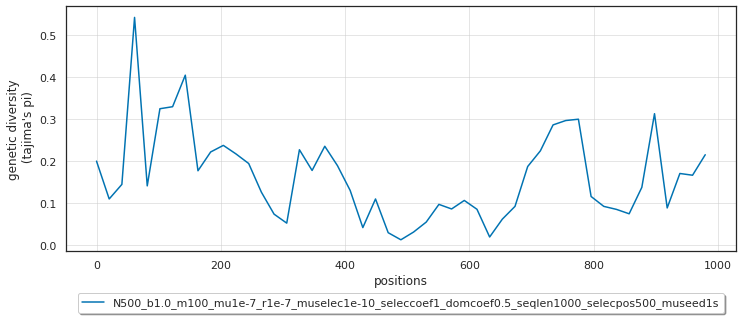

In [73]:
fig, axs = plt.subplots(1, 1,figsize=(12, 5), sharex=True, sharey=True)
subfig_diversity(models, ax=axs, y_label=True, font_scale=1, legend_pos=-0.15)

In [74]:
pd.read_csv("./data/N500_b1.0_m100_mu1e-7_r1e-7_muselec1e-10_seleccoef1_domcoef0.5_seqlen1000_selecpos500_museed1s/run_0.csv")

,position,origin_generation,abs_population_freq,selection_coefficient,dominance_coefficient,active_mutations
0,500.026,-1,1,1,0.5,1
1,500.026,0,1,1,0.5,1
2,500.026,1,2,1,0.5,1
3,500.026,2,2,1,0.5,1
4,500.026,3,6,1,0.5,1
5,500.026,4,10,1,0.5,1
6,500.026,5,18,1,0.5,1
7,500.026,6,33,1,0.5,1
8,500.026,7,54,1,0.5,1
9,500.026,8,97,1,0.5,1


In [ ]:
for i in [1.0, 0.75, 0.5, 0.25]:
    i = (round(i,2))
    output_directory = "./data/N500_b" + str(i) + "_m50_mu5e-8_r5e-8_muselec5e-9_seleccoef1_domcoef0.5_seqlen5000_selecpos2500_museed0s/"

    sleepy(n_simulations=100, num_generations=100000, N=500, m=50, b=i, gc=50, mu=5e-8, r=5e-8, L=5000, mu_selection_rates="5e-9", 
             selection_coefficients="1",dominance_coefficients="0.5", selection_positions="2500",
             mutation_in_seeds=False, stop_after_mrca=False, debug_print=False, output_name="run",
             selection_activation_generation=20000,
             output_directory=output_directory,n_parallel=10, continue_from=0, print_cmd=True, slurm=True);

In [1]:
!rsync -a --ignore-existing ga54run2@lxlogin3.lrz.de:/dss/dsshome1/lxc02/ga54run2/paper3/data .

In [178]:
models = []
for i in [1.0,0.75, 0.5, 0.25]:
    i = (round(i,2))
    path = "./data/N500_b" + str(i) + "_m50_mu5e-8_r5e-8_muselec5e-9_seleccoef1_domcoef0.5_seqlen5000_selecpos2500_museed0s/"
    model = get_diversity(path, basename(abspath(path)), mode="site")
    models.append(model)

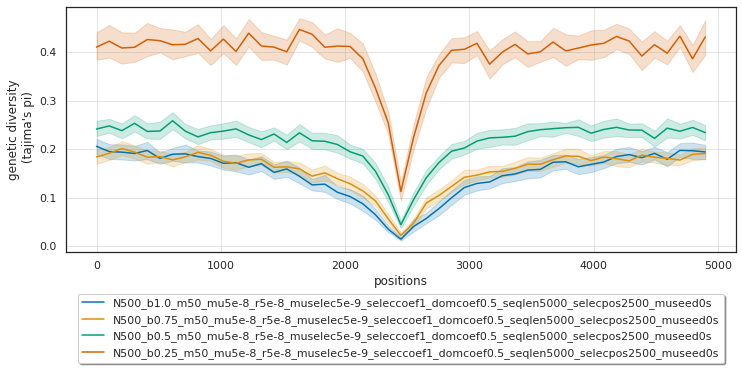

In [179]:
fig, axs = plt.subplots(1, 1,figsize=(12, 5), sharex=True, sharey=True)
subfig_diversity(models, ax=axs, y_label=True, font_scale=1, legend_pos=-0.15)

In [182]:
for i in [0.2, 0.5, 1.1]:
    i = (round(i,2))
    output_directory = "./data/N500_b1_m1_mu5e-8_r5e-8_muselec5e-9_seleccoef1_domcoef" + str(i) + "_seqlen5000_selecpos2500_museed0s/"

    sleepy(n_simulations=100, num_generations=100000, N=500, m=1, b=1, gc=50, mu=5e-8, r=5e-8, L=5000, mu_selection_rates="5e-9", 
             selection_coefficients="1",dominance_coefficients=str(i), selection_positions="2500",
             mutation_in_seeds=False, stop_after_mrca=False, debug_print=False, output_name="run",
             selection_activation_generation=20000,
             output_directory=output_directory,n_parallel=10, continue_from=0, print_cmd=True, slurm=True);

sleepy --num_generations 100000 --N 500 --m 1 --b 1 --gc 50 --mu 5e-08 --r 5e-08 --L 5000 --mu_selection_rates 5e-9 --selection_coefficients 1 --dominance_coefficients 0.2 --selection_positions 2500 --selection_activation_generation 20000 --mutation_in_seeds False --stop_after_mrca False --debug_print False --output_name run_$i --output_directory ./data/N500_b1_m1_mu5e-8_r5e-8_muselec5e-9_seleccoef1_domcoef0.2_seqlen5000_selecpos2500_museed0s/ 
sleepy --num_generations 100000 --N 500 --m 1 --b 1 --gc 50 --mu 5e-08 --r 5e-08 --L 5000 --mu_selection_rates 5e-9 --selection_coefficients 1 --dominance_coefficients 0.5 --selection_positions 2500 --selection_activation_generation 20000 --mutation_in_seeds False --stop_after_mrca False --debug_print False --output_name run_$i --output_directory ./data/N500_b1_m1_mu5e-8_r5e-8_muselec5e-9_seleccoef1_domcoef0.5_seqlen5000_selecpos2500_museed0s/ 
sleepy --num_generations 100000 --N 500 --m 1 --b 1 --gc 50 --mu 5e-08 --r 5e-08 --L 5000 --mu_selecti

In [192]:
models = []
for i in [0.2, 0.5, 1.1]:
    i = (round(i,2))
    path = "./data/N500_b1_m1_mu5e-8_r5e-8_muselec5e-9_seleccoef1_domcoef" + str(i) + "_seqlen5000_selecpos2500_museed0s/"
    model = get_diversity(path, basename(abspath(path)), mode="site")
    models.append(model)

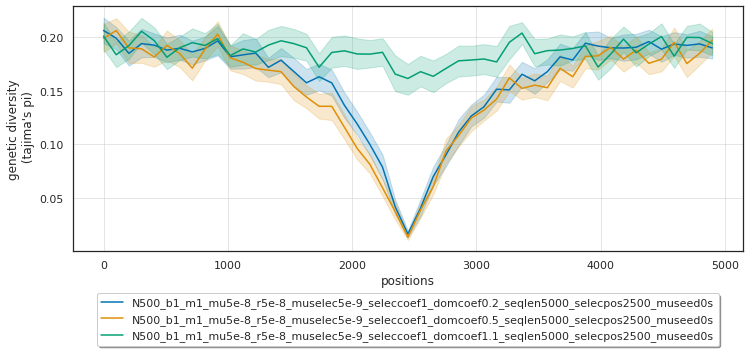

In [193]:
fig, axs = plt.subplots(1, 1,figsize=(12, 5), sharex=True, sharey=True)
subfig_diversity(models, ax=axs, y_label=True, font_scale=1, legend_pos=-0.15)

In [183]:
for i in [0.2, 0.5, 1.1]:
    i = (round(i,2))
    output_directory = "./data/N500_b0.5_m50_mu5e-8_r5e-8_muselec5e-9_seleccoef1_domcoef" + str(i) + "_seqlen5000_selecpos2500_museed0s/"

    sleepy(n_simulations=100, num_generations=100000, N=500, m=50, b=0.5, gc=50, mu=5e-8, r=5e-8, L=5000, mu_selection_rates="5e-9", 
             selection_coefficients="1",dominance_coefficients=str(i), selection_positions="2500",
             mutation_in_seeds=False, stop_after_mrca=False, debug_print=False, output_name="run",
             selection_activation_generation=20000,
             output_directory=output_directory,n_parallel=10, continue_from=0, print_cmd=True, slurm=True);

sleepy --num_generations 100000 --N 500 --m 50 --b 0.5 --gc 50 --mu 5e-08 --r 5e-08 --L 5000 --mu_selection_rates 5e-9 --selection_coefficients 1 --dominance_coefficients 0.2 --selection_positions 2500 --selection_activation_generation 20000 --mutation_in_seeds False --stop_after_mrca False --debug_print False --output_name run_$i --output_directory ./data/N500_b0.5_m50_mu5e-8_r5e-8_muselec5e-9_seleccoef1_domcoef0.2_seqlen5000_selecpos2500_museed0s/ 
sleepy --num_generations 100000 --N 500 --m 50 --b 0.5 --gc 50 --mu 5e-08 --r 5e-08 --L 5000 --mu_selection_rates 5e-9 --selection_coefficients 1 --dominance_coefficients 0.5 --selection_positions 2500 --selection_activation_generation 20000 --mutation_in_seeds False --stop_after_mrca False --debug_print False --output_name run_$i --output_directory ./data/N500_b0.5_m50_mu5e-8_r5e-8_muselec5e-9_seleccoef1_domcoef0.5_seqlen5000_selecpos2500_museed0s/ 
sleepy --num_generations 100000 --N 500 --m 50 --b 0.5 --gc 50 --mu 5e-08 --r 5e-08 --L 50

In [194]:
models = []
for i in [0.2, 0.5, 1.1]:
    i = (round(i,2))
    path = "./data/N500_b0.5_m50_mu5e-8_r5e-8_muselec5e-9_seleccoef1_domcoef" + str(i) + "_seqlen5000_selecpos2500_museed0s/"
    model = get_diversity(path, basename(abspath(path)), mode="site")
    models.append(model)

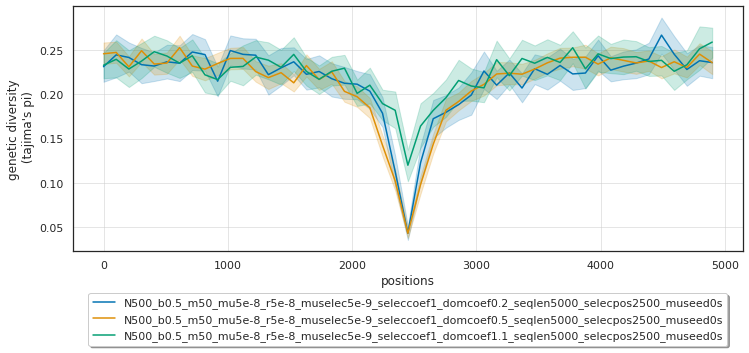

In [195]:
fig, axs = plt.subplots(1, 1,figsize=(12, 5), sharex=True, sharey=True)
subfig_diversity(models, ax=axs, y_label=True, font_scale=1, legend_pos=-0.15)

In [3]:
20000*5e-8

0.001